# Homework 4: Analyzing Rates of Sea Level Rise
In this homework, you'll investigate sea level change using data from the ECCO state estimate. You'll look at spatial differences over the past few decades and then compare how sea level on the California coast compares to the global mean.

Begin by importing the modules you'll need for this notebook:

In [18]:
# import packages here
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import os
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm

## Part 1: Download Sea Surface Height Data
To begin this exercise, download all of the available sea surface height data (1992-2017) from the ECCO Version 4 Release 4 output. There are several different variables for sea surface height pertaining to different components and corrections. In this homework, we'll use the `SSHDYN` variable which is equivalent to what satellites would measure from space.

To obtain the data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes.

In [8]:
# define the path to the folder where the SSH data has been download on your machine
ssh_folder = 'D:/DATA/ECCO/Version4/Release4/interp_monthly/SSHDYN'

## Part 2: Plot Total Sea Level Rise 1992-2017
As a first look into how sea level has changed in the past several decades, we'll look at the differences between two time periods at the beginning and end of the available model output: January 1992 and January 2017. It is important to use the same month because variations in sea level also have a seasonal cycle (as we'll see below). Begin by reading in the data:

In [25]:
# read in the longitude, latitude, and model ssh grid in January 1992 (SSHDYN_1992_01.nc)
seaLvlJan92 =  os.path.join(ssh_folder,'SSHDYN_1992_01.nc')
ds = xr.open_dataset(seaLvlJan92)
longitude = np.array(ds['longitude'][:])
latitude = np.array(ds['latitude'][:])
SSHJan92 = np.array(ds['SSHDYN'][:])
ds.close()
print(np.shape(SSHJan92))
SSHJan92= SSHJan92[0,:,:]
ds

# read in the model ssh grid in January 2017 (SSHDYN_2017_01.nc)
seaLvlJan17 =  os.path.join(ssh_folder,'SSHDYN_2017_01.nc')
ds2 = xr.open_dataset(seaLvlJan17)
SSHJan17 = np.array(ds2['SSHDYN'][:])
ds2.close()
SSHJan17= SSHJan17[0,:,:]

(1, 360, 720)


In [26]:
ds

<xarray.Dataset>
Dimensions:    (i: 720, j: 360, time: 1, nv: 2)
Coordinates:
  * i          (i) int64 0 1 2 3 4 5 6 7 8 ... 712 713 714 715 716 717 718 719
  * j          (j) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * time       (time) datetime64[ns] 1992-01-16T12:00:00
    latitude   (j) float64 ...
    longitude  (i) float64 ...
    timestep   (time) int64 ...
    time_bnds  (time, nv) datetime64[ns] ...
Dimensions without coordinates: nv
Data variables:
    SSHDYN     (time, j, i) float64 ...
Attributes: (12/20)
    product_time_coverage_start:  1992-01-01T12:00:00
    author:                       Ou Wang and Ian Fenty
    Insitution:                   JPL
    product_version:              ECCO Version 4 Release 4
    time_units:                   days since 1992-01-01 00:00:00
    Conventions:                  CF-1.6
    ...                           ...
    nz:                           1
    geospatial_vertical_units:    meter
    geospatial_vertical_max:      0
    date_created:                 Wed Oct 23 23:06:44 2019
    time_coverage_start:          1992-01-01T00:00:00
    time_coverage_end:            1992-02-01T00:00:00

Now, make a plot of the difference between January 2017 and January 1992. Be sure to add a colorbar with a divergent colormaps and set the color bounds to be equal in the positive and negative directions.

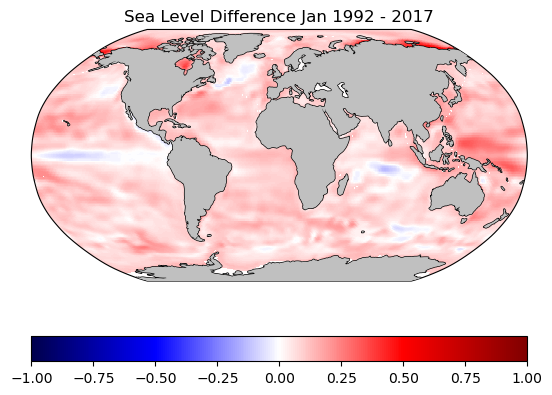

In [23]:
# make a plot of the differences between 2017 and 1992
fig = plt.figure()
ax = plt.axes(projection=ccrs.Robinson())

# plot the seaice
plt.pcolormesh(longitude, latitude, SSHJan17 - SSHJan92, vmin=-1, vmax=1, cmap='seismic',
               transform=ccrs.PlateCarree())
plt.colorbar(orientation = 'horizontal')


# add coastlines
plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver')
plt.gca().coastlines()

# format the axes
plt.title('Sea Level Difference Jan 1992 - 2017')
plt.show()

### Questions:
Where are the largest increases in sea level observed between these two time periods? Are there any locations on the globe where sea level has fallen? If so, where?

Answer: the largest increases in sea level are at the north coast of Russia and Alaska, with larger increases in the west Pacific. Sea level has fallen along the equator in the pacific and in the middle of the indian ocean.

## Part 3: Create a Timeseries of Sea Surface Height in California
Next, we'll make a timeseries of sea surface height at a point off the California coast near San José. A close location in the model is at 37$^{\circ}$N, 122$^{\circ}$W. Begin by finding the closest row and column in the model grid to this longitude and latitude.

In [53]:
# define the latitude and longitude
lon = -122
lat = 37

# find the row and column closest to the location of the point off the CA coast
# note that you have already read in the longitude and latitude if the grid to make the plot above
lon_index = lon +360

# find the lat index closest to 57.4 N
lat_index = lat +180

# sanity check
print('The longitude at index',lon_index,'is',longitude[lon_index])
print('The latitude at index',lat_index,'is',latitude[lat_index])

The longitude at index 238 is -60.75
The latitude at index 217 is 18.75


Now, armed with your sample location, loop through each sea surface height file to make a timeseries of sea level rise between 1992 and 2017. Every time you access a file, sample the model grid at the row and column you identified above.

In [54]:
file_list = []

# loop through the 12 months
for year in range(1992,2017):
    for month in range(1,13):
        file_list.append('SSHDYN_'+str(year)+'_'+'{:02d}'.format(month)+'.nc')

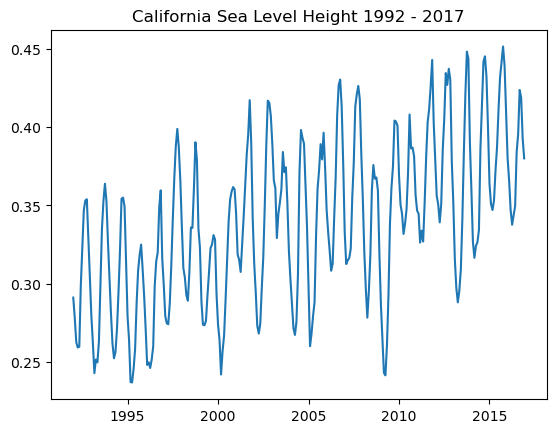

In [60]:
# create a timeseries of ssh at the point above by looping through all of the ssh files
# each time through the loop, sample the ssh grid at the row and column identified above
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second

cal_ssh_vals = np.zeros((len(file_list),))
months = np.arange(len(ssh_vals))

# convert to "decimal years"
dec_yrs = 1992 + months/12

# loop through each file
for i in range(len(file_list)):
    # identify path to the data file
    month_file = os.path.join(ssh_folder ,file_list[i])
    
    # read in the data 
    ds = xr.open_dataset(month_file)
    SSHDYN = np.array(ds['SSHDYN'][:])

    
    
    height = SSHDYN[0][lat_index][lon_index]
    ds.close()

    
    cal_ssh_vals[i] = height
    
plt.title("California Sea Level Height 1992 - 2017")
plt.plot(dec_yrs, cal_ssh_vals)

## Part 4: Create a Timeseries of Global Mean Sea Surface Height
Next, make a timeseries of sea surface height averaged across the globe. Your loop should look quite similar to that above - you'll just need to make a slight change to average across the whole ocean rather than sampling at a single point.

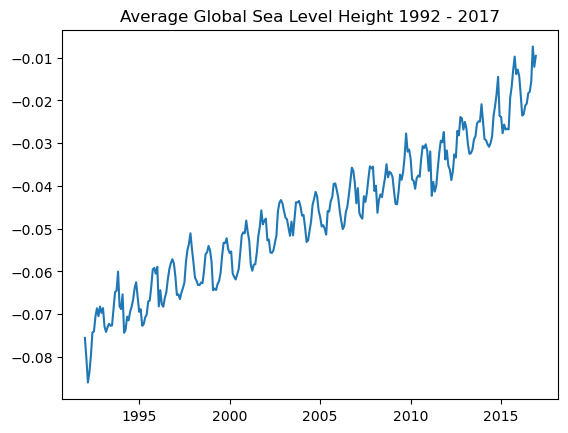

In [59]:
# create a timeseries of the global mean ssh by looping through all of the ssh files
# each time through the loop, take the mean of the ssh grid at the row and column identified above
# when you take the mean, be sure to exclude 0 values, which pertain to land
# your timeseries should be an (N,2) array with time in the first column and ssh values in the second

ssh_vals = np.zeros((len(file_list),))
months = np.arange(len(ssh_vals))

# convert to "decimal years"
dec_yrs = 1992 + months/12

# loop through each file
for i in range(len(file_list)):
    # identify path to the data file
    month_file = os.path.join(ssh_folder ,file_list[i])
    
    # read in the data 
    ds = xr.open_dataset(month_file)
    SSHDYN = np.array(ds['SSHDYN'][:])

    
    
    avg_height = np.mean(SSHDYN)
    ds.close()

    
    ssh_vals[i] = avg_height
    
plt.title("Average Global Sea Level Height 1992 - 2017")
plt.plot(dec_yrs, ssh_vals)

## Part 5: Compute Trends in Sea Surface Height
To compare the two timeseries, compute trends by fitting a line to each timeseries and examining the slope. Print out each trend in mm/yr, rounded to 2 decimal places. Note that the units of sea surface height are in meters.

In [62]:
# compute the trends in SLR by fitting a line to the CA and the global mean timeseries
cal_line_coefficients = np.polyfit(dec_yrs, cal_ssh_vals, 1)

line_coefficients = np.polyfit(dec_yrs, ssh_vals, 1)

# print out the statistics in mm/yr for each timeseries
print(cal_line_coefficients)
print(line_coefficients)


[ 3.97481750e-03 -7.62809204e+00]
[ 2.18020063e-03 -4.41705866e+00]


### Question:
How does the trend in sea level rise in California compare to the global mean rate?

Answer: *Enter your answer here*

## Part 6: Plot the Timeseries of Sea Surface Height
Finally, plot the two timeseries on the same plot along with their trend lines. Be sure to label your axes and include a legend.

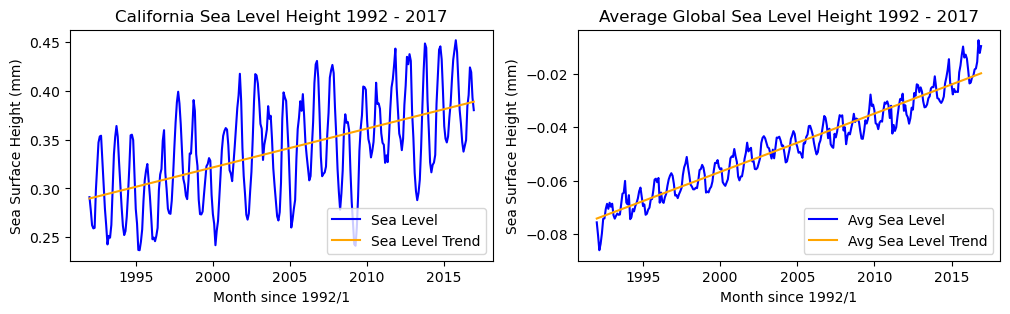

In [68]:
# create your plot here
fig = plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.title("California Sea Level Height 1992 - 2017")
plt.ylabel('Sea Surface Height (mm)')
plt.xlabel('Month since 1992/1')


plt.plot(dec_yrs, cal_ssh_vals,'-', color='blue', label='Sea Level')
m1 = cal_line_coefficients[0]
b1 = cal_line_coefficients[1]
plt.plot(dec_yrs, m1*dec_yrs+b1,'-', color='orange', label='Sea Level Trend')
plt.legend(loc = 4)

plt.subplot(1,2,2)
plt.title("Average Global Sea Level Height 1992 - 2017")
plt.ylabel('Sea Surface Height (mm)')
plt.xlabel('Month since 1992/1')


plt.plot(dec_yrs, ssh_vals,'-', color='blue', label='Avg Sea Level')
m2 = line_coefficients[0]
b2 = line_coefficients[1]
plt.plot(dec_yrs, m2*dec_yrs+b2,'-', color='orange', label='Avg Sea Level Trend')
plt.legend(loc = 4)

### Questions:

How do the timeseries for Calfiornia and the global mean compare? Comment on their variability. What are the two highest years of sea level in California? What oceanographic phenomenon happened during this time?

Answer: The timeseries for California Varies more and has a lesser trend than the average global trend, but both are still increasing during this timeframe.
The timeseries for the average global sea level height varies less but increases much more year to year than the california graph.
The two years with the highest sea level hight in california were 2014 and 2015 when there was a regional marine heatwave and El Nino back to back which both increased ocean temperatures, leading to higher sea levels.